In [522]:
# Au début du notebook
import time
start_time = time.time()

<h1 style="text-align:center;color:#06344ef6;font-size:50px;font-family:Bell MT ;border:solid"> Initiation au machine learning : Projet final 2024 - 2025</h1>

## Sommaire

Nous utiliserons l'ensemble de données [Ames Housing](http://jse.amstat.org/v19n3/decock.pdf) qui a été compilé pour la première fois par Dean De Cock. Il s'agit d'un ensemble de 1 460 maisons résidentielles à Ames, dans l'Iowa, chacune décrite par 80 caractéristiques. Nous l'utiliserons pour prédire le prix final des maisons. Dans cet exemple, nous n'utiliserons que les **n** caractéristiques les plus intéressantes.



**<h1 style="color:#06344ef6;text-align:center;font-size:35px;font-family:Bodoni MT"> MODELISATION </h1>**


## importation des modules

In [523]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as LGBMRegressor
from yellowbrick.regressor import ResidualsPlot
import missingno as msno
import pickle
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [524]:
data= pd.read_csv("../data/data_apuree.csv")
data.head(3)


,Prix de vente,Type de logement,Zonage (Classification),Façade (en pieds),Superficie du lot (pieds²),Type de route,Forme du lot,Topographie du terrain,Services publics disponibles,Configuration du lot,...,Climatisation centrale,Système électrique,Surface du premier étage,Surface du deuxième étage,Surface finie basse qualité (pieds²),Surface habitable totale,Salles de bain complètes sous-sol,Demi-salles de bain sous-sol,Salles de bain complètes,Demi-salles de bain
0,12.247699,2 ÉTAGES 1946 ET PLUS RÉCENT,Résidentiel basse densité,65.0,8450.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Disjoncteurs,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0
1,12.109016,1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES,Résidentiel basse densité,80.0,9600.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Double façade,...,Oui,Disjoncteurs,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0
2,12.317171,2 ÉTAGES 1946 ET PLUS RÉCENT,Résidentiel basse densité,68.0,11250.0,Pavé,Légèrement irrégulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Disjoncteurs,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0


### FONCTIONS POUR PERFORMANCES DES MODELES

In [525]:
def get_all_performances(value_train: tuple,
                         values_test: tuple,
                         metrics: list,
                        ) -> pd.DataFrame:
    """ Get all performance metrics listed in `metrics`

    Args:
        value_train (tuple): (y_train, y_train_pred)
        values_test (tuple): (y_test, y_test_pred)
        metrics (list): list of metrics to compute


    Returns:
        pd.DataFrame: column names are: ["metric", "train", "test"]

    """
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [526]:
METRICS = [metrics.r2_score,
           metrics.root_mean_squared_error,
           metrics.mean_absolute_percentage_error,
           metrics.max_error,
          ]

### Importation

In [527]:
# Importation
data = pd.read_csv('../data/data_apuree.csv')

In [528]:
data.shape
data

,Prix de vente,Type de logement,Zonage (Classification),Façade (en pieds),Superficie du lot (pieds²),Type de route,Forme du lot,Topographie du terrain,Services publics disponibles,Configuration du lot,...,Climatisation centrale,Système électrique,Surface du premier étage,Surface du deuxième étage,Surface finie basse qualité (pieds²),Surface habitable totale,Salles de bain complètes sous-sol,Demi-salles de bain sous-sol,Salles de bain complètes,Demi-salles de bain
0,12.247699,2 ÉTAGES 1946 ET PLUS RÉCENT,Résidentiel basse densité,65.0,8450.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Disjoncteurs,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0
1,12.109016,1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES,Résidentiel basse densité,80.0,9600.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Double façade,...,Oui,Disjoncteurs,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0
2,12.317171,2 ÉTAGES 1946 ET PLUS RÉCENT,Résidentiel basse densité,68.0,11250.0,Pavé,Légèrement irrégulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Disjoncteurs,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0
3,11.849405,2 ÉTAGES 1945 ET PLUS ANCIEN,Résidentiel basse densité,60.0,9550.0,Pavé,Légèrement irrégulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot d'angle,...,Oui,Disjoncteurs,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0
4,12.429220,2 ÉTAGES 1946 ET PLUS RÉCENT,Résidentiel basse densité,84.0,14260.0,Pavé,Légèrement irrégulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Double façade,...,Oui,Disjoncteurs,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,12.072547,2 ÉTAGES 1946 ET PLUS RÉCENT,Résidentiel basse densité,62.0,7917.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Disjoncteurs,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0
1456,12.254868,1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES,Résidentiel basse densité,85.0,13175.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Disjoncteurs,1831.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0
1457,12.493133,2 ÉTAGES 1945 ET PLUS ANCIEN,Résidentiel basse densité,66.0,9042.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Disjoncteurs,1188.0,1141.0,0.0,2340.0,0.0,0.0,2.0,0.0
1458,11.864469,1 ÉTAGE 1946 ET PLUS RÉCENT - TOUS STYLES,Résidentiel basse densité,68.0,9717.0,Pavé,Régulier,Plat/Niveau,"Tous les services publics (Électricité, Gaz, E...",Lot intérieur,...,Oui,Fusibles anciens,1078.0,0.0,0.0,1078.0,1.0,0.0,1.0,0.0


In [529]:
data.describe()

,Prix de vente,Façade (en pieds),Superficie du lot (pieds²),Année de construction,Année de rénovation,Surface de parement (pieds²),Surface finie sous-sol,Surface finie sous-sol 2,Surface non finie sous-sol,Total surface sous-sol,Surface du premier étage,Surface du deuxième étage,Surface finie basse qualité (pieds²),Surface habitable totale,Salles de bain complètes sous-sol,Demi-salles de bain sous-sol,Salles de bain complètes,Demi-salles de bain
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,12.023088,69.115068,9682.476712,1971.787671,1984.865753,92.047945,431.089041,32.921233,556.537671,1055.985616,1151.851370,337.728767,0.0,1498.917123,0.413699,0.056164,1.565068,0.382877
std,0.352713,16.503986,3469.444734,28.872129,20.645407,140.590668,412.214952,100.533075,414.582219,346.847701,333.655006,415.251008,0.0,450.721489,0.492665,0.230318,0.550916,0.502885
min,11.385103,36.000000,3316.000000,1916.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,520.000000,673.000000,0.000000,0.0,848.000000,0.000000,0.000000,0.000000,0.000000
25%,11.775105,60.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.0,1129.500000,0.000000,0.000000,1.000000,0.000000
50%,12.001512,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.0,1464.000000,0.000000,0.000000,2.000000,0.000000
75%,12.273736,79.000000,11601.500000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.0,1776.750000,1.000000,0.000000,2.000000,1.000000
max,12.694656,104.000000,17400.000000,2007.000000,2010.000000,456.000000,1274.000000,396.000000,1468.000000,1753.000000,1831.000000,1141.000000,0.0,2466.000000,1.000000,1.000000,3.000000,2.000000


In [530]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 49 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Prix de vente                         1460 non-null   float64
 1   Type de logement                      1460 non-null   object 
 2   Zonage (Classification)               1460 non-null   object 
 3   Façade (en pieds)                     1460 non-null   float64
 4   Superficie du lot (pieds²)            1460 non-null   float64
 5   Type de route                         1460 non-null   object 
 6   Forme du lot                          1460 non-null   object 
 7   Topographie du terrain                1460 non-null   object 
 8   Services publics disponibles          1460 non-null   object 
 9   Configuration du lot                  1460 non-null   object 
 10  Inclinaison du terrain                1460 non-null   object 
 11  Quartier         

In [531]:
variables_qualitatives = data.select_dtypes(include=['object', 'category']).columns
variables_qualitatives
# Identification des colonnes numériques
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
numeric_cols.remove('Prix de vente')
print(numeric_cols, variables_qualitatives)

['Façade (en pieds)', 'Superficie du lot (pieds²)', 'Année de construction', 'Année de rénovation', 'Surface de parement (pieds²)', 'Surface finie sous-sol', 'Surface finie sous-sol 2', 'Surface non finie sous-sol', 'Total surface sous-sol', 'Surface du premier étage', 'Surface du deuxième étage', 'Surface finie basse qualité (pieds²)', 'Surface habitable totale', 'Salles de bain complètes sous-sol', 'Demi-salles de bain sous-sol', 'Salles de bain complètes', 'Demi-salles de bain'] Index(['Type de logement', 'Zonage (Classification)', 'Type de route',
       'Forme du lot', 'Topographie du terrain',
       'Services publics disponibles', 'Configuration du lot',
       'Inclinaison du terrain', 'Quartier', 'Proximité (1ère condition)',
       'Proximité (2e condition)', 'Type de bâtiment', 'Style de maison',
       'Qualité globale', 'État général', 'Style de toit', 'Matériau du toit',
       'Revêtement extérieur (1)', 'Revêtement extérieur (2)',
       'Qualité extérieure', 'État exté

## Sélection des variables explicatives

In [532]:
#  soit votre DataFrame et 'SalePrice' la variable cible
X = data.drop(columns=['Prix de vente'])

y = data['Prix de vente']


In [533]:
X_encode = pd.get_dummies(data=X,
                          columns=variables_qualitatives,
                          drop_first=True,
                         )
X_encode.shape

(1460, 190)

Création des variables Dummy pour les index des feature importances

In [534]:
# Colonnes à encoder ordinalement
ode_cols =['LotShape','LandSlope',
    'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC'

]
ode_cols=[
    'Façade (en pieds)', 'Superficie du lot (pieds²)', 'Année de construction',
    'Année de rénovation', 'Surface de parement (pieds²)', 'Surface finie sous-sol',
    'Surface finie sous-sol 2', 'Surface non finie sous-sol', 'Total surface sous-sol',
    'Surface du premier étage', 'Surface du deuxième étage',
    'Surface finie basse qualité (pieds²)', 'Surface habitable totale',
    'Salles de bain complètes sous-sol', 'Demi-salles de bain sous-sol',
    'Salles de bain complètes', 'Demi-salles de bain'
]

# Colonnes à encoder en one-hot
ohe_cols =[
    'MSSubClass', 'MSZoning', 'Street',  'LandContour', 'Utilities',
    'LotConfig',  'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'Foundation', 'Heating', 'CentralAir','Electrical'
]

ohe_cols=[
    'Type de logement', 'Zonage (Classification)', 'Type de route', 'Forme du lot',
    'Topographie du terrain', 'Services publics disponibles', 'Configuration du lot',
    'Inclinaison du terrain', 'Quartier', 'Proximité (1ère condition)',
    'Proximité (2e condition)', 'Type de bâtiment', 'Style de maison',
    'Qualité globale', 'État général', 'Style de toit', 'Matériau du toit',
    'Revêtement extérieur (1)', 'Revêtement extérieur (2)', 'Qualité extérieure',
    'État extérieur', 'Type de fondation', 'Qualité du sous-sol',
    'État général du sous-sol', 'Exposition du sous-sol',
    'Type de finition sous-sol (1)', 'Type de finition sous-sol (2)',
    'Type de chauffage', 'Qualité du chauffage', 'Climatisation centrale',
    'Système électrique'
]

### Pipelines

Dans le cadre de notre pipeline, nous appliquerons les étapes suivantes:

- **Standardisation des variables quantitatives**: Nous centrerons et réduirons ces variables afin de les ramener à une échelle commune, avec une moyenne nulle et un écart-type égal à un.

- **Encodage des variables catégorielles**: Nous transformerons ces variables en variables indicatrices (dummy variables) pour les rendre exploitables par les algorithmes d'apprentissage automatique.

Ces transformations permettront d'optimiser les performances de notre modèle en assurant une meilleure comparabilité des variables et en facilitant leur interprétation.

In [535]:
# Pipeline pour les variables numériques
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler())  # Normalisation
])
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encodage ordinal, handle unknown categories
])


# Pipeline pour les variables avec encodage one-hot
onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))  # Encodage one-hot
])


In [536]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_cols),
    ('ord', ordinal_pipeline, ode_cols),
    ('ohe', onehot_pipeline, ohe_cols)
])


In [537]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie...
                                                   'Qualité globale',
                                                   'État général',
                                                   'Style de toit',
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])]))])

In [538]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1095 lignes,
Test: 365 lignes.



In [539]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def display_feature_importance(best_model,numeric_cols,ode_cols,ohe_cols):
    # Extract the final estimator model
    final_estimator_name = list(best_model.named_steps.keys())[-1]
    model = best_model.named_steps[final_estimator_name]
    
    # Check if the model has a coef_ attribute (linear models)
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    else:
        raise ValueError(f"The final model {final_estimator_name} does not have 'coef_' attribute. Cannot plot feature importance.")
    
    # Get feature names after preprocessing
    # For numeric features
    num_features = best_model.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].get_feature_names_out(input_features=numeric_cols)
    
    # For ordinal features
    ord_features = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['ordinal_encoder'].get_feature_names_out(input_features=ode_cols)
    
    # For one-hot encoded features
    ohe_features = best_model.named_steps['preprocessor'].transformers_[2][1].named_steps['onehot_encoder'].get_feature_names_out(input_features=ohe_cols)

    # Combine all feature names
    feature_names = np.concatenate([num_features, ord_features, ohe_features])

    # Select features with non-zero coefficients
    selected_features = feature_names[coefficients != 0]

    # Create a DataFrame to display results
    coefficients_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients[coefficients != 0]
    })

    # Sort the coefficients by absolute value
    coefficients_df_sorted = coefficients_df.sort_values("Coefficient", key=lambda v: abs(v), ascending=False)

    # Plot the results
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Coefficient', y='Feature', data=coefficients_df_sorted.head(n), palette='viridis')
    plt.title("Feature Importance in the Optimized Model")
    plt.axvline(x=0, color='.6')
    plt.show()


In [577]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def display_feature_importance_2(best_model, numeric_cols, ode_cols, ohe_cols, n):
    # Récupérer le nom de l'estimateur final
    final_estimator_name = list(best_model.named_steps.keys())[-1]
    model = best_model.named_steps[final_estimator_name]
    try:
        importances = model.feature_importances_
    except:
        raise ValueError(f"Le modèle {final_estimator_name} n'est pas pris en charge.")

    # Obtenir les noms des caractéristiques après transformation
    num_features = best_model.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler'].get_feature_names_out(input_features=numeric_cols)
    
    # Pour les caractéristiques ordinales
    ord_features = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['ordinal_encoder'].get_feature_names_out(input_features=ode_cols)
    
    # Pour les caractéristiques encodées one-hot
    ohe_features = best_model.named_steps['preprocessor'].transformers_[2][1].named_steps['onehot_encoder'].get_feature_names_out(input_features=ohe_cols)

    # Combiner les noms des caractéristiques
    feature_names = np.concatenate([num_features, ord_features, ohe_features])

    # Créer un DataFrame pour afficher les résultats
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Trier les caractéristiques par ordre d'importance décroissante
    importance_df_sorted = importance_df.sort_values("Importance", key=lambda v: abs(v), ascending=False)

    # Afficher les caractéristiques sélectionnées et leurs importances
    print(importance_df_sorted.head(n))

    # Représenter graphiquement les importances
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=importance_df_sorted.head(n), palette='viridis')
    plt.title("Importance des variables dans le modèle optimisé")
    plt.xlabel('Importance')
    plt.ylabel('Variable')
    plt.axvline(x=0, color='.6')
    plt.show()

## REGRESSION LINEAIRE

In [541]:
lr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("regressor", LinearRegression())
    ]
)

In [542]:
# definir les hyperparametres
param_grid_lr = {
    "regressor__fit_intercept": [True, False],
}

GS_lr = GridSearchCV(lr_pipe, param_grid_lr, cv=10, scoring="r2", return_train_score=True)
GS_lr

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fin...
                                                                          'Exposition '
                                                                          'du '
                                                                          'sous-sol',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(1)',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                    

In [543]:
# Exécuter la recherche sur la grille
GS_lr.fit(X_train, y_train)
# meilleur combinaison
best_params = GS_lr.best_params_
print(f"Best params: {best_params}")
best_GS_lr=GS_lr.best_estimator_


Best params: {'regressor__fit_intercept': True}


In [544]:
grid_cv_results = GS_lr.cv_results_
pd.DataFrame(grid_cv_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.988031,0.342058,0.051019,0.035304,True,{'regressor__fit_intercept': True},0.827031,0.652703,0.769681,0.862479,...,0.934755,0.936311,0.935966,0.934379,0.934716,0.940731,0.936183,0.937328,0.936279,0.001715
1,0.981224,0.273901,0.038457,0.011242,False,{'regressor__fit_intercept': False},0.822881,0.456663,0.756026,0.848158,...,0.933996,0.935738,0.935665,0.933565,0.934384,0.939985,0.935690,0.936949,0.935742,0.001706


In [545]:
# predictions
y_test_pred_lr = GS_lr.predict(X_test)
y_train_pred_lr = GS_lr.predict(X_train)

In [546]:
## Comparaison réelle et prédiction (train et test)
fig = make_subplots(rows=1, cols=2, shared_yaxes=False)

datasets = [("Train", y_train, y_train_pred_lr), ("Test", y_test, y_test_pred_lr)]

for idx, (name, y_true, y_pred) in enumerate(datasets):
    col = idx + 1
    fig.add_trace(go.Scatter(x=y_true, y=y_pred, mode="markers", name=name), row=1, col=col)

    fig.add_trace(go.Scatter(x=[y_true.min(), y_true.max()],
                             y=[y_true.min(), y_true.max()],
                             mode="lines", name="Diagonal", line=dict(color="black", dash="dash")),
                  row=1, col=col)

fig.update_layout(title_text="Comparaison réelle et prédiction (train et test)", showlegend=True)
fig.show()


## RESIDUS

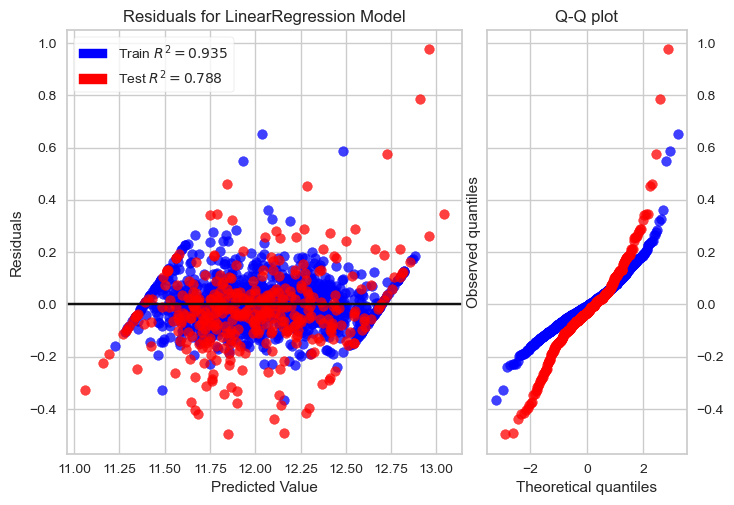

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

<Figure size 800x550 with 0 Axes>

In [547]:
# Visualisation des résidus
from yellowbrick.regressor import ResidualsPlot

res_viz = ResidualsPlot(lr_pipe,
                        is_fitted="auto",
                        qqplot=True,
                        hist=False,
                        train_color="blue",
                        test_color="red"
                       )
res_viz.fit(X_train, y_train)
res_viz.score(X_test, y_test)
res_viz.show(clear_figure=True)


In [548]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, GS_lr.predict(X_train)),
                     values_test=(y_test, GS_lr.predict(X_test)),
                     metrics=METRICS
                    )
perform
joblib.dump(perform, '../ressource/performance/GS_lr_perform.pkl')
joblib.dump(GS_lr, '../ressource/modele/GS_lr_model.pkl')

['../ressource/modele/GS_lr_model.pkl']

C:\Users\pc\AppData\Local\Temp\ipykernel_17124\3126304115.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




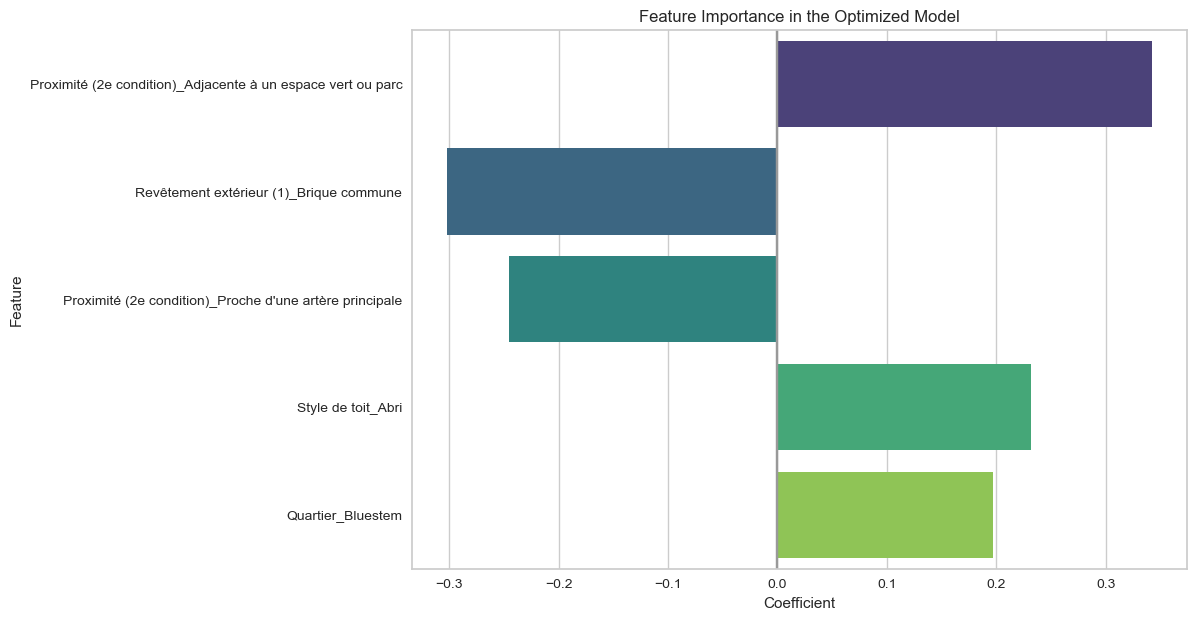

In [549]:
display_feature_importance(best_GS_lr,numeric_cols,ode_cols,ohe_cols,5)

# ELASTIC NET

In [550]:
EN_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", ElasticNet())]
)
EN_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Style de toit',
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', ElasticNet())])

In [551]:
EN_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Style de toit',
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', ElasticNet())])

In [552]:
# predictions
y_test_pred_EN = EN_pipe.predict(X_test)
y_train_pred_EN = EN_pipe.predict(X_train)

In [553]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, y_train_pred_EN),
                     values_test=(y_test, y_test_pred_EN),
                     metrics=METRICS)
perform

,metric,train,test
0,r2_score,0.818061,0.127311
1,root_mean_squared_error,0.149984,0.332076
2,mean_absolute_percentage_error,0.009171,0.020386
3,max_error,0.762891,1.034465


### Optimisation des hyperparametres

In [554]:
# optimisation des hyperparamètres
param_grid_EN = {
    "regressor__alpha": [0.005, 0.01, 0.2, 0.3, 0.5, 0.7],
    "regressor__l1_ratio" : [0.001, 0.01, 0.5, 0.3, 0.7, 0.8],
    "regressor__fit_intercept" : [True, False]
}

GS_EN = GridSearchCV(EN_pipe, param_grid_EN, cv=5, scoring="r2", return_train_score=True)

In [555]:
# les meilleurs paramètres
GS_EN.fit(X_train, y_train)

best_params = GS_EN.best_params_
print(f"Best params: {best_params}")

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.076649040847948, tolerance: 0.011140301377969487

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.030050121920033, tolerance: 0.01074974732432053

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.021304957574464, tolerance: 0.010597465337453253

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7970322598729784, tolerance

Best params: {'regressor__alpha': 0.005, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.001}


c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.146531662121204, tolerance: 0.013538631495021224



In [556]:
# entrainement du meilleur modele
best_elasticnet_model = GS_EN.best_estimator_
best_elasticnet_model.fit(X_train,y_train)

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.146531662121204, tolerance: 0.013538631495021224



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', ElasticNet(alpha=0.005, l1_ratio=0.001))])

In [557]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, best_elasticnet_model.predict(X_train)),
                     values_test=(y_test, best_elasticnet_model.predict(X_test)),
                     metrics=METRICS
                    )
perform

,metric,train,test
0,r2_score,0.930233,0.826963
1,root_mean_squared_error,0.092877,0.147869
2,mean_absolute_percentage_error,0.005699,0.008929
3,max_error,0.667763,0.904705


In [558]:
joblib.dump(perform, '../ressource/performance/ElasticNet_perform.pkl')
joblib.dump(best_elasticnet_model, '../ressource/modele/ElasticNet_model.pkl')

['../ressource/modele/ElasticNet_model.pkl']

C:\Users\pc\AppData\Local\Temp\ipykernel_17124\3126304115.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




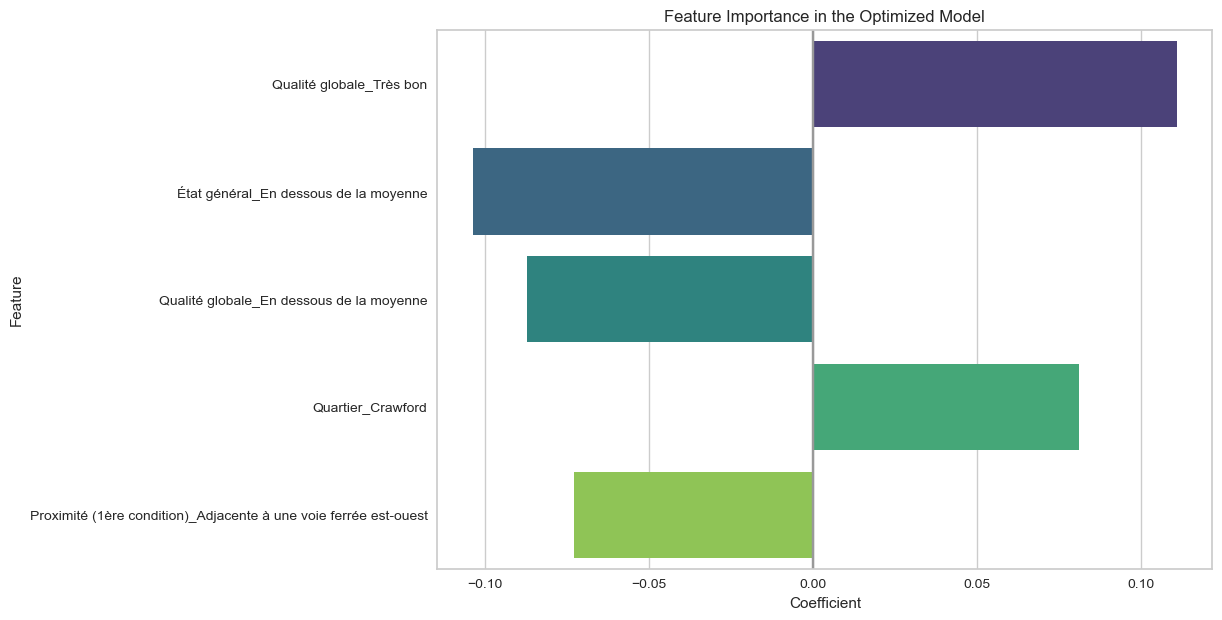

In [559]:
display_feature_importance(best_elasticnet_model,numeric_cols,ode_cols,ohe_cols,5)

# Random Forest

In [560]:
randf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor())]
)
randf_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', RandomForestRegressor())])

In [561]:
# Premier entrainement
randf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', RandomForestRegressor())])

In [562]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, randf_pipe.predict(X_train)),
                     values_test=(y_test, randf_pipe.predict(X_test)),
                     metrics=METRICS)
perform

,metric,train,test
0,r2_score,0.983562,0.751985
1,root_mean_squared_error,0.045082,0.177030
2,mean_absolute_percentage_error,0.002730,0.011079
3,max_error,0.261762,0.703946


Optimisation des Hyperparametres

In [563]:
# optimisation des hyperparamètres
param_grid_rf = {
    'regressor__n_estimators': [700, 600],
     'regressor__min_samples_split': [5],
    'regressor__max_depth': [None],
    'regressor__min_samples_leaf': [2],
    #'regressor__max_features': ['auto'],#'sqrt'
    'regressor__bootstrap': [True], # False
}

GS_rf = GridSearchCV(randf_pipe, param_grid_rf, cv=5, scoring="r2", return_train_score=True)
GS_rf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [None],
                         'regressor__min_samples_leaf': [2],
                         'regressor__min_samples_split': [5],
                         'regressor__n_estimators': [700, 600]},
             return_train_score=True, scoring='r2')

In [564]:
# les meilleurs paramètres
GS_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [None],
                         'regressor__min_samples_leaf': [2],
                         'regressor__min_samples_split': [5],
                         'regressor__n_estimators': [700, 600]},
             return_train_score=True, scoring='r2')

In [565]:
# les meilleurs paramètres
best_params = GS_rf.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__bootstrap': True, 'regressor__max_depth': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 700}


In [566]:
# entrainement du meilleur modele
best_randf_model = GS_rf.best_estimator_
best_randf_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor',
                 RandomForestRegressor(min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=700))])

## Evaluation des performances

In [570]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, best_randf_model.predict(X_train)),
                     values_test=(y_test, best_randf_model.predict(X_test)),
                     metrics=METRICS
                    )
perform
joblib.dump(perform, '../ressource/performance/rfr_perform.pkl')
joblib.dump(best_randf_model, '../ressource/modele/rfr_model.pkl')

['../ressource/modele/rfr_model.pkl']

In [573]:
print(best_randf_model.named_steps.keys())

dict_keys(['preprocessor', 'regressor'])


Feature importance

                      Feature  Importance
29   Surface habitable totale    0.166764
12   Surface habitable totale    0.163751
128  Qualité globale_Très bon    0.104907
19      Année de construction    0.103214
2       Année de construction    0.096294


C:\Users\pc\AppData\Local\Temp\ipykernel_17124\2749016156.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




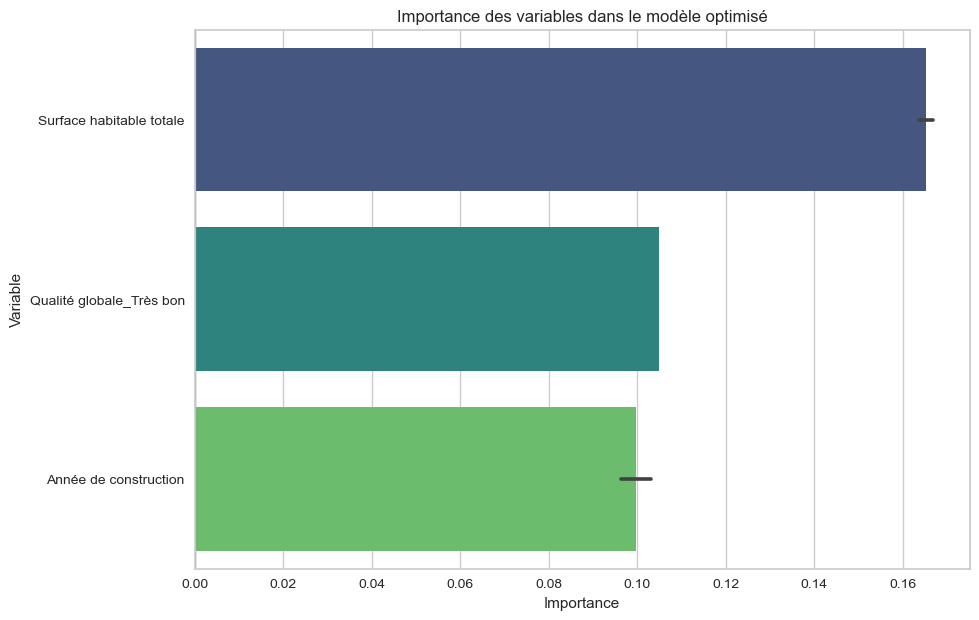

In [578]:
display_feature_importance_2(best_randf_model,numeric_cols,ode_cols,ohe_cols,5)

# XGBoost

In [579]:
xgb_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", XGBRegressor())]
)
xgb_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [580]:
# Premier entrainement
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [581]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, xgb_pipe.predict(X_train)),
                     values_test=(y_test, xgb_pipe.predict(X_test)),
                     metrics=METRICS)
perform

,metric,train,test
0,r2_score,0.999519,0.857058
1,root_mean_squared_error,0.007712,0.134396
2,mean_absolute_percentage_error,0.000433,0.008221
3,max_error,0.042398,0.696676


### Optimisation des hyperparametres

In [582]:
# optimisation des hyperparamètres
param_grid_xgb = {
     "regressor__n_estimators" : [100, 200, 300],
    "regressor__max_depth" : [3, 6, 9],
    "regressor__gamma" : [0.01, 0.1],
    "regressor__learning_rate" : [0.001, 0.01, 0.1, 1]
}
GS_xgb = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5, scoring="r2", return_train_score=True)
GS_xgb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__gamma': [0.01, 0.1],
                         'regressor__learning_rate': [0.001, 0.01, 0.1, 1],
                         'regressor__max_depth': [3, 6, 9],
                         'regressor__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='r2')

In [583]:
# les meilleurs paramètres
GS_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__gamma': [0.01, 0.1],
                         'regressor__learning_rate': [0.001, 0.01, 0.1, 1],
                         'regressor__max_depth': [3, 6, 9],
                         'regressor__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='r2')

In [584]:
# les meilleurs paramètres
best_params = GS_xgb.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__gamma': 0.01, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


In [585]:
# entrainement du meilleur modele
best_xgb_model = GS_xgb.best_estimator_
best_xgb_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                              feature_types=None, gamma=0.01, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Evaluation des performances

In [586]:
# predictions
y_train_predXGB = best_xgb_model.predict(X_train)
y_test_predXGB = best_xgb_model.predict(X_test)

# get performances in train & test
perform=get_all_performances(value_train=(y_train, y_train_predXGB),
                     values_test=(y_test, y_test_predXGB),
                     metrics=METRICS
                    )
perform
joblib.dump(perform, '../ressource/performance/xgb_perform.pkl')
joblib.dump(best_xgb_model, '../ressource/modele/xgb_model.pkl')

['../ressource/modele/xgb_model.pkl']

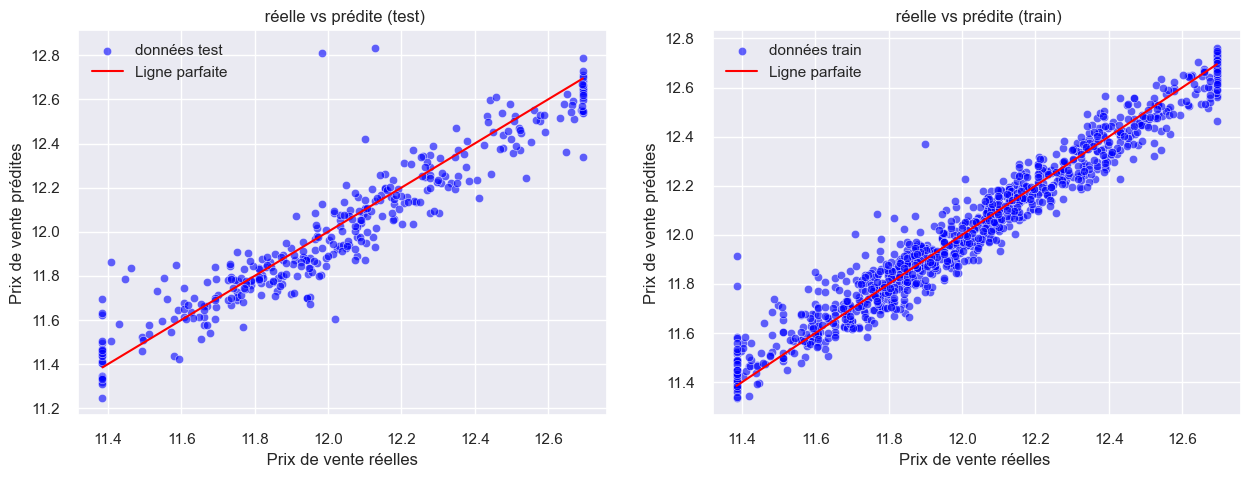

In [587]:
# graphique
sns.set()
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x = y_test, y = y_test_predXGB, alpha = 0.6, ax = axs[0], color='blue', label='données test')
sns.lineplot(x=y_test, y=y_test, ax = axs[0], color='red', label='Ligne parfaite')
axs[0].set_xlabel(" Prix de vente réelles ")
axs[0].set_ylabel("Prix de vente prédites")
axs[0].set_title(" réelle vs prédite (test)")
sns.scatterplot(x = y_train, y = y_train_predXGB, alpha = 0.6, ax = axs[1], color='blue', label='données train')
sns.lineplot(x=y_train, y=y_train, ax = axs[1], color='red', label='Ligne parfaite')
axs[1].set_xlabel("Prix de vente réelles ")
axs[1].set_ylabel("Prix de vente prédites")
axs[1].set_title(" réelle vs prédite (train)")
plt.show()

                      Feature  Importance
128  Qualité globale_Très bon    0.179168
177  Qualité extérieure_Moyen    0.121714
12   Surface habitable totale    0.073727
2       Année de construction    0.070753
32   Salles de bain complètes    0.046064


C:\Users\pc\AppData\Local\Temp\ipykernel_17124\2749016156.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




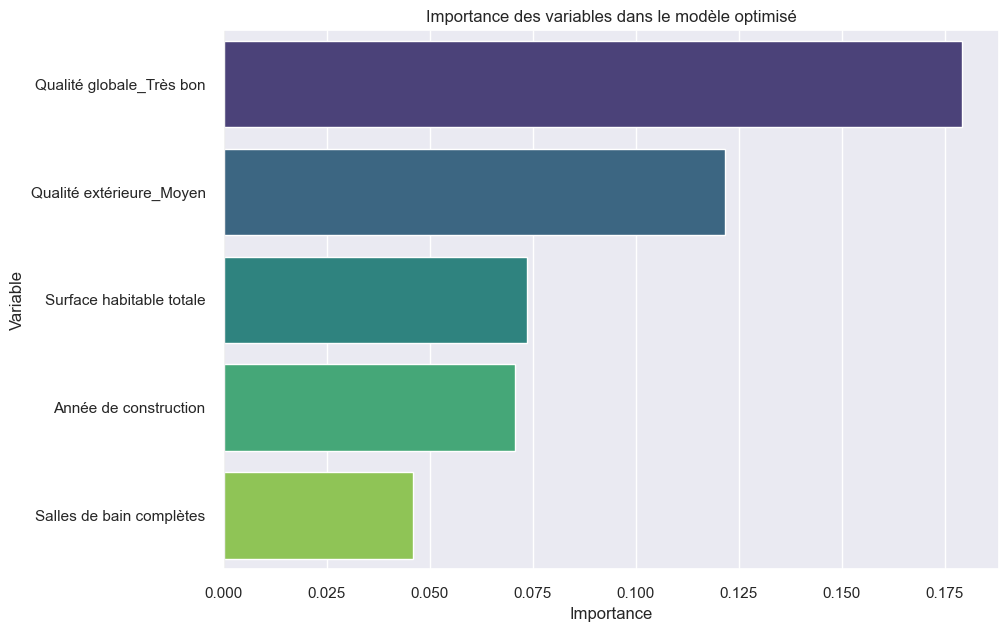

In [588]:
display_feature_importance_2(best_xgb_model,numeric_cols,ode_cols,ohe_cols,5)

In [589]:
print(best_xgb_model.named_steps.keys())

dict_keys(['preprocessor', 'regressor'])


# Light GBM

In [590]:
from lightgbm import LGBMRegressor # import the LGBMRegressor class from the lightgbm module.

lgbm_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LGBMRegressor())]
)
lgbm_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', LGBMRegressor())])

In [591]:
# premier entrainement
lgbm_pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4293
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 152
[LightGBM] [Info] Start training from score 12.022632


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Matériau du toit',
                                                   'Revêtement extérieur (1)',
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor', LGBMRegressor())])

In [592]:
# get performances in train & test
perform=get_all_performances(value_train=(y_train, lgbm_pipe.predict(X_train)),
                     values_test=(y_test, lgbm_pipe.predict(X_test)),
                     metrics=METRICS
                    )
perform

,metric,train,test
0,r2_score,0.990086,0.873634
1,root_mean_squared_error,0.035011,0.126364
2,mean_absolute_percentage_error,0.002067,0.007705
3,max_error,0.337777,0.724169


### Optimisation des hyperparametres

In [593]:
# optimisation des hyperparamètres
param_grid_lgb = {
    'regressor__num_leaves': [131, 255],
    'regressor__max_depth': [-1, 30],
    'regressor__learning_rate': [0.001, 0.2],
    'regressor__n_estimators': [10, 50],
   # 'regressor__min_split_gain': [0.0, 0.2],
    #'regressor__min_child_samples': [10, 30],
    #'regressor__subsample': [0.8, 0.9, 1.0],
    #'regressor__reg_alpha': [0.0, 0.1, 0.5],
    #'regressor__reg_lambda': [0.001, 0.1],
    #'regressor__objective': ['mse'],
    #'regressor__feature_fraction': 0.75,
    #'regressor__bagging_fraction': 0.75,
    #'regressor__bagging_freq': 5,
}

GS_lgb = GridSearchCV(lgbm_pipe, param_grid_lgb, cv=5, scoring="r2", return_train_score=True)
GS_lgb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(1)',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', LGBMRegressor())]),
             param_grid={'regressor__learning_rate': [0.001, 0.2],
                         'regressor__max_depth': [-1, 30],
                         'regressor__n_estimators': [10, 50],
                         'regressor__num_leaves': [131, 255]},
             return_train_score=True, scoring='r2')

In [594]:
# les meilleurs paramètres
GS_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 876, number of used features: 147
[LightGBM] [Info] Start training from score 12.014136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Façade '
                                                                          '(en '
                                                                          'pieds)',
                                                                          'Superficie '
                                                                          'du '
                                                                          'lot '
                                                                          '(pieds²)',
                                                                          'Année '
                                                                          'de '
                                                                          'construction',
                                                                          'Année '
                                                                          'de '
                                                                          'rénovation',
                                                                          'Surface '
                                                                          'de '
                                                                          'parement '
                                                                          '(pieds²)',
                                                                          'Surface '
                                                                          'fini...
                                                                          'sous-sol '
                                                                          '(1)',
                                                                          'Type '
                                                                          'de '
                                                                          'finition '
                                                                          'sous-sol '
                                                                          '(2)',
                                                                          'Type '
                                                                          'de '
                                                                          'chauffage',
                                                                          'Qualité '
                                                                          'du '
                                                                          'chauffage',
                                                                          'Climatisation '
                                                                          'centrale', ...])])),
                                       ('regressor', LGBMRegressor())]),
             param_grid={'regressor__learning_rate': [0.001, 0.2],
                         'regressor__max_depth': [-1, 30],
                         'regressor__n_estimators': [10, 50],
                         'regressor__num_leaves': [131, 255]},
             return_train_score=True, scoring='r2')

In [595]:
# les meilleurs paramètres
best_params = GS_lgb.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__learning_rate': 0.2, 'regressor__max_depth': -1, 'regressor__n_estimators': 50, 'regressor__num_leaves': 131}


In [596]:
# entrainement du meilleur modele
best_lgb_model = GS_lgb.best_estimator_
best_lgb_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4293
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 152
[LightGBM] [Info] Start training from score 12.022632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor',
                 LGBMRegressor(learning_rate=0.2, n_estimators=50,
                               num_leaves=131))])

In [597]:
# entrainement du meilleur modele
best_lgb_model = GS_lgb.best_estimator_
best_lgb_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4293
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 152
[LightGBM] [Info] Start training from score 12.022632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Façade (en pieds)',
                                                   'Superficie du lot (pieds²)',
                                                   'Année de construction',
                                                   'Année de rénovation',
                                                   'Surface de parement '
                                                   '(pieds²)',
                                                   'Surface finie sous-sol',
                                                   'Surface finie sous-sol 2',
                                                   'Surface non finie s...
                                                   'Revêtement extérieur (2)',
                                                   'Qualité extérieure',
                                                   'État extérieur',
                                                   'Type de fondation',
                                                   'Qualité du sous-sol',
                                                   'État général du sous-sol',
                                                   'Exposition du sous-sol',
                                                   'Type de finition sous-sol '
                                                   '(1)',
                                                   'Type de finition sous-sol '
                                                   '(2)',
                                                   'Type de chauffage',
                                                   'Qualité du chauffage',
                                                   'Climatisation centrale', ...])])),
                ('regressor',
                 LGBMRegressor(learning_rate=0.2, n_estimators=50,
                               num_leaves=131))])

In [598]:
perform=get_all_performances(value_train=(y_train, best_lgb_model.predict(X_train)),
                     values_test=(y_test, best_lgb_model.predict(X_test)),
                     metrics=METRICS
                    )
perform


,metric,train,test
0,r2_score,0.992667,0.855727
1,root_mean_squared_error,0.030112,0.135020
2,mean_absolute_percentage_error,0.001722,0.008239
3,max_error,0.286900,0.710773


In [599]:
joblib.dump(perform, '../ressource/performance/lgb_perform.pkl')

['../ressource/performance/lgb_perform.pkl']

                         Feature  Importance
1     Superficie du lot (pieds²)         195
12      Surface habitable totale         181
2          Année de construction         156
8         Total surface sous-sol         142
7     Surface non finie sous-sol         137
5         Surface finie sous-sol         132
9       Surface du premier étage         124
3            Année de rénovation         112
0              Façade (en pieds)         101
4   Surface de parement (pieds²)          84


C:\Users\pc\AppData\Local\Temp\ipykernel_17124\2749016156.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




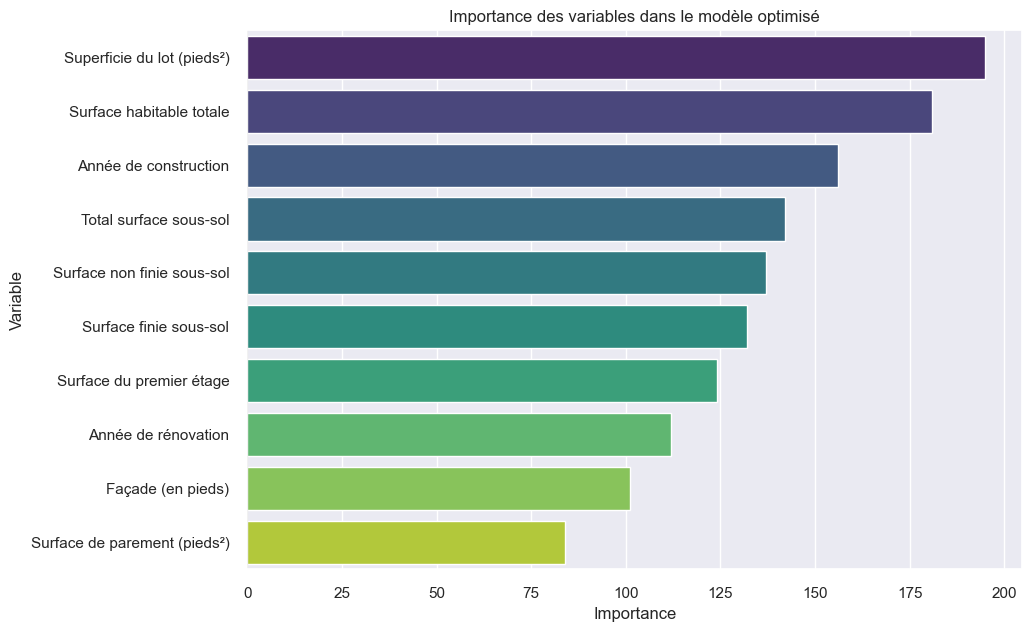

In [600]:
display_feature_importance_2(best_lgb_model,numeric_cols,ode_cols,ohe_cols,10)

# CHOIX DU MODELE FINAL

In [601]:
# Regression lineaire
score_Lr_Train = GS_lr.score(X_train, y_train)
score_Lr_Test = GS_lr.score(X_test, y_test)

# ElasticNet
score_EN_Train = best_elasticnet_model.score(X_train, y_train)
score_EN_Test = best_elasticnet_model.score(X_test, y_test)

# Random Forest
score_RF_Train = best_randf_model.score(X_train, y_train)
score_RF_Test = best_randf_model.score(X_test, y_test)

# XGBoost
score_XGB_Train = best_xgb_model.score(X_train, y_train)
score_XGB_Test = best_xgb_model.score(X_test, y_test)

# Light GBM
score_LGB_Train = best_lgb_model.score(X_train, y_train)
score_LGB_Test = best_lgb_model.score(X_test, y_test)

C:\Users\pc\AppData\Local\Temp\ipykernel_17124\3152736353.py:12: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




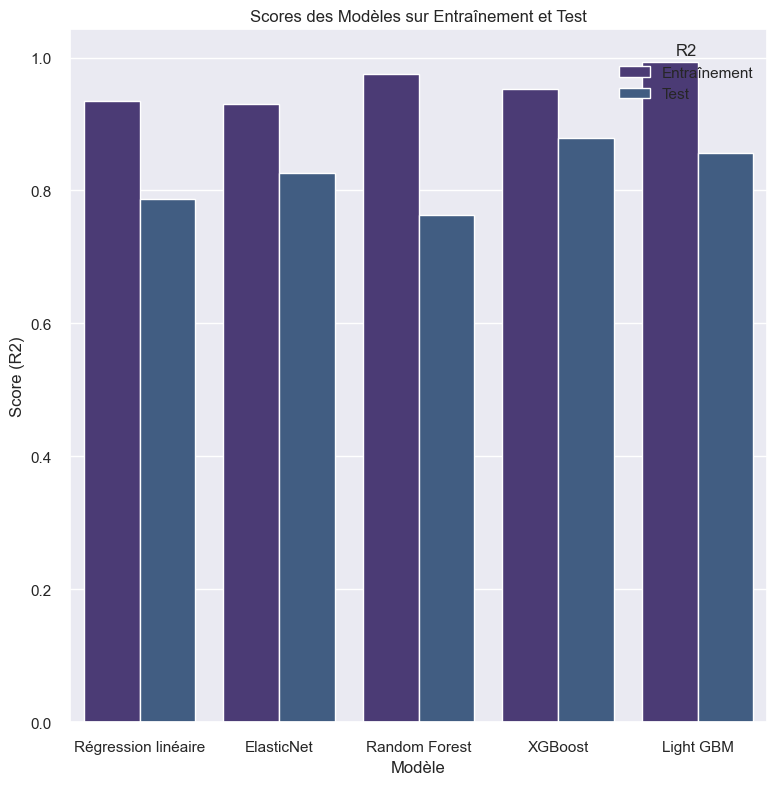

In [602]:
models = ['Régression linéaire', 'ElasticNet', 'Random Forest', 'XGBoost', 'Light GBM']
train_scores = [score_Lr_Train, score_EN_Train, score_RF_Train, score_XGB_Train, score_LGB_Train]
test_scores = [score_Lr_Test, score_EN_Test, score_RF_Test, score_XGB_Test, score_LGB_Test]

scores_df = pd.DataFrame({'Modèle': models * 2,
                          'Score': train_scores + test_scores,
                          'R2': ['Entraînement'] * len(models) + ['Test'] * len(models)})

sns.set_palette("viridis")

plt.figure(figsize=(9, 9))
sns.barplot(x='Modèle', y='Score', hue='R2', data=scores_df, ci=None)
plt.xlabel('Modèle')
plt.ylabel('Score (R2)')
plt.title('Scores des Modèles sur Entraînement et Test')
plt.legend(title='R2')

plt.show()

## Model final retenu : Light GBM

In [603]:
best_lgb_model.fit(X,y)
print (f'Score final - : {best_lgb_model.score(X,y):.7f}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4583
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 164
[LightGBM] [Info] Start training from score 12.023088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Prediction des prix des maisons

In [604]:
y_pred = best_lgb_model.predict(X_test)


## comparaisons des valeurs predites et des valeurs reelles

In [605]:
comparaison=pd.DataFrame(y_pred,columns=["Prédites"],index=y_test.index)
comparaison["Réelles"]=y
np.exp(comparaison.head())

,Prédites,Réelles
400,244379.158821,245501.0
426,267185.412741,275001.0
310,171044.619671,165601.0
1176,120473.196344,119501.0
1170,168271.835010,171001.0


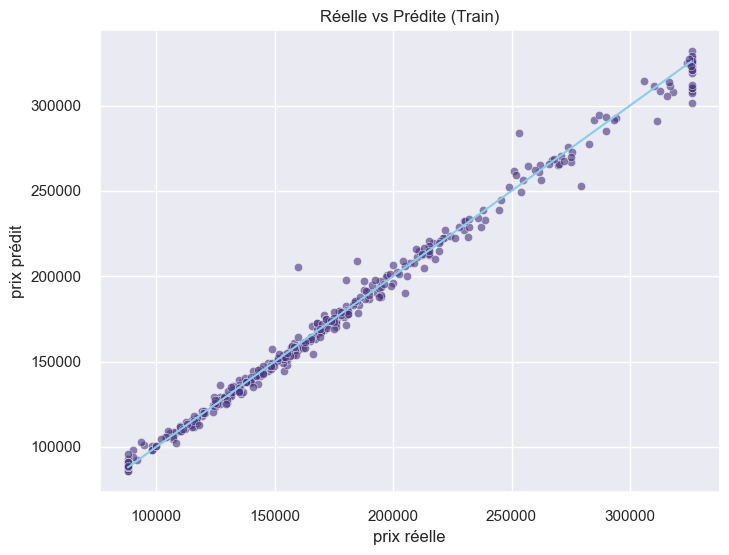

In [606]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x=np.exp(y_test), y=np.exp(y_pred), alpha=0.6)
sns.lineplot(x=np.exp(y_test), y=np.exp(y_test), color='skyblue')  # Ligne de référence en rouge
plt.xlabel("prix réelle")
plt.ylabel("prix prédit")
plt.title("Réelle vs Prédite (Train)")

plt.show()

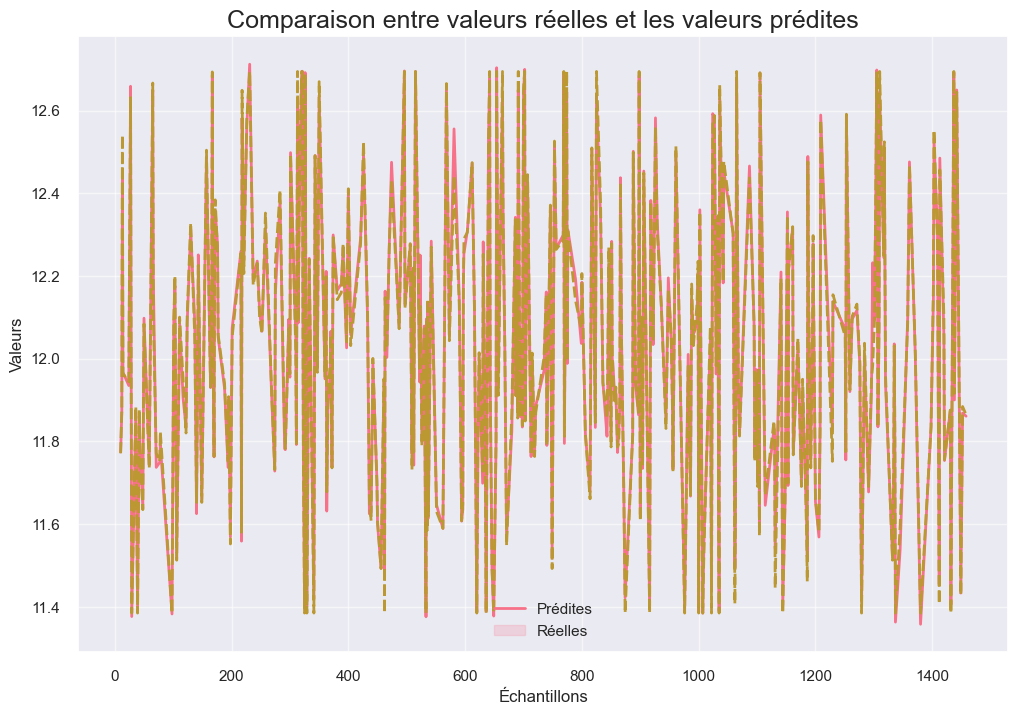

In [607]:
# graphique de comparaison
plt.figure(figsize=(12, 8))
sns.set_palette("husl")
sns.lineplot(data=comparaison[['Prédites', 'Réelles']], linewidth=2)
plt.title("Comparaison entre valeurs réelles et les valeurs prédites", size=18)
plt.xlabel("Échantillons")
plt.ylabel("Valeurs")
plt.legend(labels=['Prédites', 'Réelles'])
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

## Enrégistrement du modèle final

In [608]:
joblib.dump(best_lgb_model, '../ressource/modele_final/lgb_model.pkl')
joblib.dump(best_lgb_model, '../ressource/modele/lgb_model.pkl')

['../ressource/modele/lgb_model.pkl']

In [609]:
# À la fin du notebook
end_time = time.time()
duration = end_time - start_time
print(f"Durée totale d'exécution : {duration:.2f} secondes")

Durée totale d'exécution : 2877.14 secondes
